# Tensorflow Mnist
## 說明
[keras_mnist](https://github.com/shaoeChen/deeplearning/blob/master/keras/keras_cnn_mnist.ipynb)  
MNIST是一個進入深度學習的經典案例，在理解後tensorflow的基礎框架概念之後，我們利用這個經典案例來更深入認識tensorflow。

## 認識資料集
[MNIST](http://yann.lecun.com/exdb/mnist)是一個手寫數字辨識的資料集，0-9，總共十個類別，資料集的部份可以從`keras.datasets.mnist`取得之外，也可以透過`tensorflow.examples.tutorials.mnist`取得。

In [100]:
#  取得資料集
from tensorflow.examples.tutorials.mnist import input_data
datasets_mnist = input_data.read_data_sets('mnist_data/', one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


上面warning主要說明著該function未來會棄用，要改用其它。  
read_data_sets中，第一個放的參數是該資料集要放在執行目錄的那一個資料夾內，而one_hot=True則代表label直接下載的時候就是one_hot encoder，我們不需要再另外處理。

註：可見[keras_dnn_mnist](https://github.com/shaoeChen/deeplearning/blob/master/keras/keras_dnn_Mnist.ipynb)中[In 140]說明

In [101]:
X_train_original = datasets_mnist.train.images
X_test_original = datasets_mnist.test.images
y_train_original = datasets_mnist.train.labels
y_test_original = datasets_mnist.test.labels

#  驗證資料集，如果需要的話
# X_validator_original = datasets_mnist.validation.images
# y_validator_original = datasets_mnist.validation.labels

In [102]:
X_train = np.rollaxis(X_train_original, 1, 0)
X_test = np.rollaxis(X_test_original, 1, 0)
y_train = np.rollaxis(y_train_original, 1, 0)
y_test = np.rollaxis(y_test_original, 1, 0)

資料集取得之後，首要確認資料的dimension，從dimension可以確認，這資料已經是平準化過的，所以如果是以dnn為模型的時候不需要再特別處理，但如果要以cnn來處理的話，就需要針對dimension做reshape。

註：調整dimension：`X_train_original.reshape(55000,28,28)`   

In [103]:
print('X_train_dimension:', X_train.shape)
print('X_test_dimension:', X_test.shape)
print('y_train_dimension:', y_train.shape)
print('y_test_dimension:', y_test.shape)

X_train_dimension: (784, 55000)
X_test_dimension: (784, 10000)
y_train_dimension: (10, 55000)
y_test_dimension: (10, 10000)


## 實作模型
神經網路的流程如下：
1. 定義輸出入
2. 初始化參數權重
3. forward propagation
4. 計算cost function
5. backpropagation

模型結構如下：
1. L=3(普遍來說，有學習參數的才會算一層)
    * hidden layer-2
    * output layer-1
2. units
    * l0:(784, None)\_input layer
        * input layer no weights
    * l1:128
        * weights dimension: 128, 784
        * bias dimension: 128, 1
    * l2:256
        * weights dimension: 256, 128
        * bias dimension: 256, 1 
    * l3:10\_output layer
        * weights dimension: 10, 256
        * bias dimension: 10, 1
3. activation
    * l1:relu
    * l2:relu
    * l3:softmax

當然這只是一個簡單的說明，相關深度學習觀念可參考吳恩達老師的網易課程或coursera課程，範例上為了實作上的直觀，所以並不會很模組化的去架構，而是一步一步的建構。

註：相關的神經網路觀念可參考個人課程筆記[andrew_Deeplearning](https://hackmd.io/c/HJUZTKMZz/https%3A%2F%2Fhackmd.io%2Fs%2Frk9-9anlG)  
註：dimension的部份因為觀念來自andrew的課程，所以datasets的dimension會是(n, m)，n為特徵數，m為資料筆數

### 載入需求套件

In [104]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

### 定義輸出入
0. tf.reset_default_graph()
    * 初始化graph
        * 後篇說明用途
1. 輸出、入的部份我們會利用`tf.placeholder`來做一個宣告
    * 因為輸入的數量並不確定，所以宣告的時候會以None來帶入，這並不會造成異常

In [105]:
#  後篇說明
tf.reset_default_graph()

In [106]:
#  輸入的dimension是m=784
X = tf.placeholder(tf.float32, shape=[784, None])
#  輸出的dimension是class=10
y = tf.placeholder(tf.float32, shape=[10, None])

### 初始化參數權重
hidden layer都會帶著一組學習參數(權重)，透過不斷的迭代優化讓參數可以擬合我們的數據集，在forward propagation之後計算成本函數接著透過backpropagation更新學習參數。

它是會迭代更新異動，所以我們會將學習參數宣告為`tf.Variable`並且以`tf.random_normal`來初始化權重。

function hints:  
* [tf.random_normal](https://www.tensorflow.org/api_docs/python/tf/random_normal)
* [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)
* [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)

In [107]:
W1 = tf.Variable(initial_value=tf.random_normal(shape=[128, 784]), name='W1')
b1 = tf.Variable(initial_value=tf.zeros(shape=[128, 1]), name='b1')
W2 = tf.Variable(initial_value=tf.random_normal(shape=[256, 128]), name='W2')
b2 = tf.Variable(initial_value=tf.zeros(shape=[256, 1]), name='b2')
W3 = tf.Variable(initial_value=tf.random_normal(shape=[10, 256]), name='W3')
b3 = tf.Variable(initial_value=tf.zeros(shape=[10, 1]), name='b3')

### forward propagation
前向傳播：linear activate->nonlinear activate->linear activate->nonlinear linear    
1. Z1 = W1 \* X + b1
2. A1 = tf.nn.relu(Z1)
3. Z2 = W2 \* A1 + b2
4. A2 = tf.nn.relu(Z2)
5. Z3 = W2 \* A2 + b3

注意到，前向傳播只會計算到Z3，在tensorflow中，最後一層線性輸出會被拿來做cost function的計算

function hints:  
* [tf.add](https://www.tensorflow.org/api_docs/python/tf/add)
* [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/matmul)
* [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

註：相關計算也可以參考[tensorflow_03_Basic](https://github.com/shaoeChen/deeplearning/blob/master/tensorflow/tensorflow_03_Basic.ipynb)  
註：`tf.nn`是操作神經網路的package

In [108]:
Z1 = tf.add(tf.matmul(W1, X), b1, name='Z1')
A1 = tf.nn.relu(Z1, name='A1')
Z2 = tf.add(tf.matmul(W2, A1), b2, name='Z2')
A2 = tf.nn.relu(Z2, name='A2')
Z3 = tf.add(tf.matmul(W3, A2), b3, name='Z3')

### 計算cost function

function:  
* [tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
* [tf.nn.sofrmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)  
    * 注意到dimension的部份需為[batch\_sze, number\_class]

In [109]:
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y), logits=tf.transpose(Z3)), name='cost_function')

### backpropagation
反向傳播的部份，在framework(tensowflow)的協助之下，我們是不需要特別的處理，唯一需要定義的就是最佳化的方式，剩餘的偏微分計算就由framework來處理即可。

function:  
* [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
    * 梯度下降

註：`tf.train`是tensorflow用來訓練模型的package

In [110]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost_function)

### 模型訓練
到上面，我們已經規劃好我們的graph，接下來就要利用`tf.Session()`來執行整個flow。

epoch: 1  and cost= 1123.5582
accuracy: 0.08112727
epoch: 2  and cost= 1008.85864
accuracy: 0.086763635
epoch: 3  and cost= 914.8965
accuracy: 0.092327274
epoch: 4  and cost= 836.2512
accuracy: 0.09752727
epoch: 5  and cost= 771.69977
accuracy: 0.10261818
epoch: 6  and cost= 720.30194
accuracy: 0.10843636
epoch: 7  and cost= 679.9344
accuracy: 0.114
epoch: 8  and cost= 648.00525
accuracy: 0.121836364
epoch: 9  and cost= 621.5344
accuracy: 0.12949091
epoch: 10  and cost= 598.71234
accuracy: 0.13694546
epoch: 11  and cost= 578.44965
accuracy: 0.1444
epoch: 12  and cost= 560.0136
accuracy: 0.15212727
epoch: 13  and cost= 542.93066
accuracy: 0.16027273
epoch: 14  and cost= 526.8824
accuracy: 0.16790909
epoch: 15  and cost= 511.70343
accuracy: 0.17609091
epoch: 16  and cost= 497.2819
accuracy: 0.18345454
epoch: 17  and cost= 483.5228
accuracy: 0.19189091
epoch: 18  and cost= 470.3995
accuracy: 0.20001818
epoch: 19  and cost= 457.86786
accuracy: 0.20783636
epoch: 20  and cost= 445.88385
accu

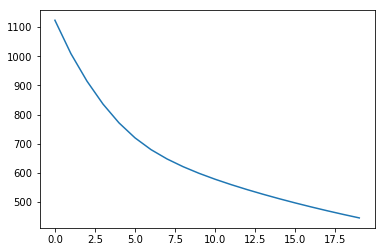

In [126]:
init = tf.global_variables_initializer()
costs = []
eopchs = 20
with tf.Session() as sess:
    #  初始化所有變數    
    sess.run(init)
    
    #  計算模型效能
    predict = tf.argmax(Z3, 0)
    label = tf.argmax(y, 0)
    acc = tf.contrib.metrics.accuracy(predict, label)    
    
    
    #  迴圈迭代計算
    for epoch in range(eopchs):
        sess.run(optimizer, feed_dict={X: X_train, y: y_train})
        cost = sess.run(cost_function, feed_dict={X: X_train, y: y_train})
        print('epoch:', epoch+1, ' and cost= ', cost)
        costs.append(cost)
        print('accuracy:', sess.run(acc, feed_dict={X: X_train, y: y_train}))
       
    
    plt.plot(range(eopchs), costs)
    plt.show()

從上面結果來看，我們成功的收斂了Cost Function，當然模型還是有很大的改進空間，但是我們只是為了對tensowflow有更直觀的理解，所以並沒有建置的非常複雜。

### TensorBoard

In [69]:
tf.summary.merge_all()
tensor_log = tf.summary.FileWriter('log/mlp', sess.graph)

注意到當前路徑應該是在log的時候才執行下列指令  
```shell
tensorboard --logdir=mlp
```

## 總結
在這個案例中，我們對tensorflow多認識了兩個package：  
1. tf.nn:對神經網路的操作，裡面有activation、dropout、conv、pool...
2. tf.train:神經網路的最佳化，裡面有梯度下降、adam、RMSProp..


另外我們也發現到，在實作模型之前我們有執行了`tf.reset_default_graph()`，它的作用後續會說明。

## 延伸閱讀
在實作的過程中發現到一件事，上層的output就是下層的input，每一層的計算就是一個線性(z=(y=wx+b))接一個非線性(relu(z))，利用這個特性我們也可以用較模組化的方式來建立模型。

In [26]:
def dnn_layer(layer_name, pre_layer, hidden_unit, activation=None):
    """
    parameter:
        layer_name:隱藏層名稱
        pre_layer:上層神經網路的輸出，如果為第一層則該輸出即為資料集X
        hidden_unit:神經單元數量
        activation:啟動函數，格式為tf.nn.xxxx
    return:
        A:輸出資料    
        
    memo:
        如果有需求的話，想法上回傳權重與偏差單元是一個不錯的作法
    """
    
    #  取得上層神經網路的unit數量
    pre_layer_unit = pre_layer.shape.as_list()[0]
    
    W = tf.Variable(initial_value=tf.random_normal(shape=[hidden_unit, pre_layer_unit]), name='W_'+layer_name)
    b = tf.Variable(initial_value=tf.zeros(shape=[hidden_unit, 1]), name='b_'+layer_name)
    Z = tf.add(tf.matmul(W, pre_layer), b, name='Z_'+layer_name)
    
    #  部份時候可能需要線性輸出，所以允許None
    if activation == None:
        A = Z
    else:
        A = activation(Z, name='A_'+layer_name)
    
    return A
    

定義好模型之後，我們就可以直接以上層輸出即為下層輸入的概念來架構神經網路，整個程式碼更直觀，而且更有結構性，似乎也有點像keras或tensorlayer，不過重點還是在對神經網路的基本觀念以及對framework的熟悉。

In [38]:
#  後篇說明
tf.reset_default_graph()

#  輸入的dimension是mx784
X = tf.placeholder(tf.float32, shape=[784, None])
#  輸出的eimension是mx10
y = tf.placeholder(tf.float32, shape=[10, None])

In [39]:
#  利用剛才定義的layer來計算
layer_1 = dnn_layer('layer_1', X, 128, tf.nn.relu)
layer_2 = dnn_layer('layer_2', layer_1, 256, tf.nn.relu)
layer_3 = dnn_layer('output_layer', layer_2, 10, None)

In [41]:
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y), logits=tf.transpose(layer_3)), name='cost_function')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost_function)

epoch: 1  and cost= 1182.2762
epoch: 2  and cost= 1051.0151
epoch: 3  and cost= 968.6061
epoch: 4  and cost= 909.9714
epoch: 5  and cost= 862.91345
epoch: 6  and cost= 821.93427
epoch: 7  and cost= 784.76917
epoch: 8  and cost= 750.33746
epoch: 9  and cost= 718.0798
epoch: 10  and cost= 687.60986
epoch: 11  and cost= 658.6306
epoch: 12  and cost= 631.03174
epoch: 13  and cost= 604.74225
epoch: 14  and cost= 579.8643
epoch: 15  and cost= 556.8481
epoch: 16  and cost= 536.20355
epoch: 17  and cost= 518.1911
epoch: 18  and cost= 502.66312
epoch: 19  and cost= 488.96198
epoch: 20  and cost= 476.50684


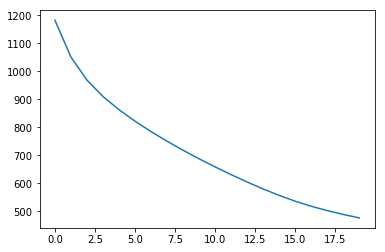

In [43]:
init = tf.global_variables_initializer()
costs = []
with tf.Session() as sess:
    #  初始化所有變數    
    sess.run(init)
    
    #  迴圈迭代計算
    for epoch in range(20):
        sess.run(optimizer, feed_dict={X: X_train, y: y_train})
        cost = sess.run(cost_function, feed_dict={X: X_train, y: y_train})
        print('epoch:', epoch+1, ' and cost=', cost)
        costs.append(cost)
    
    plt.plot(range(20), costs)
    plt.show()